In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from enum import Enum

In [2]:
def load_data(data_path):
    # Load csv files
    data = []
    num_runs = 0
    for file in os.listdir(data_path):
        if file.endswith('.csv'):
            with open(os.path.join(data_path, file)) as csvfile:
                reader = csv.reader(csvfile)
                new_run = []
                for row in reader:
                    time = float(row[0])
                    event = row[1].strip() #remove trailing whitespace
                    new_run.append((time, event))
                data.append(new_run)
                
                num_runs += 1

    return data


In [3]:
expert_data_path = 'telemetry/expert'
expert_data = load_data(expert_data_path)

novice_data_path = 'telemetry/novice'
novice_data = load_data(novice_data_path)

# make sure we loaded data
assert len(expert_data) > 0
assert len(novice_data) > 0

In [4]:
class Events(Enum):
    #pressure events
    PRESSURE_AMBIENT = 'pressure_ambient'
    PRESSURE_SEALING = 'pressure_sealing'
    PRESSURE_BREAK_IN = 'pressure_break-in'

    #experiment stage events
    CELL_APPROACH = 'cell_approach'
    GIGASEAL = 'gigaseal'
    BREAK_IN = 'break-in'

    #pipette events
    PIPETTE_BROKEN = 'pipette_broken'
    PIPETTE_CLOGGED = 'pipette_clogged'
    PIPETTE_CLEANED = 'pipette_cleaned'
    PIPETTE_REPLACED = 'pipette_replaced'


In [5]:
def create_graph(expert_data, novice_data, title, xlabel, ylabel):
    #create line graph with error bars
    data_len = len(expert_data) #assume expert and novice data have same length
    x = np.arange(data_len) + 1 #numbering starts at 1
    y_expert = np.mean(expert_data, axis=0)
    y_novice = np.mean(novice_data, axis=0)

    # #use min and max to get error bars
    # yerr = np.array([np.min(data, axis=0), np.max(data, axis=0)])
    # yerr = np.abs(yerr - y)

    #use standard deviation to get error bars
    yerr_expert = np.std(expert_data, axis=0)
    yerr_novice = np.std(novice_data, axis=0)

    #only number x axis at whole numbers
    xticks = np.arange(0, data_len + 1, 1)
    plt.xticks(xticks)

    #plot data
    plt.errorbar(x, y_expert, yerr=yerr_expert, fmt='-o', color='blue', ecolor='lightblue', elinewidth=1, capsize=6)
    plt.errorbar(x, y_novice, yerr=yerr_novice, fmt='-o', color='red', ecolor='lightcoral', elinewidth=1, capsize=6)

    #add legend
    plt.legend(['Expert', 'Novice'])

    #increase resolution
    # plt.rcParams['figure.dpi'] = 300

    #add title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.savefig('pipette_breaks.png')
    
    plt.show()

def fix_data_length(data, good_len = 5):
    fixed_data = []
    for i, run_times in enumerate(data):
        if len(run_times) < good_len:
            #run is too short -- remove
            continue
        elif len(run_times) > good_len:
            #run is too long -- truncate
            run_times = run_times[:good_len]
        fixed_data.append(run_times)
    
    return fixed_data

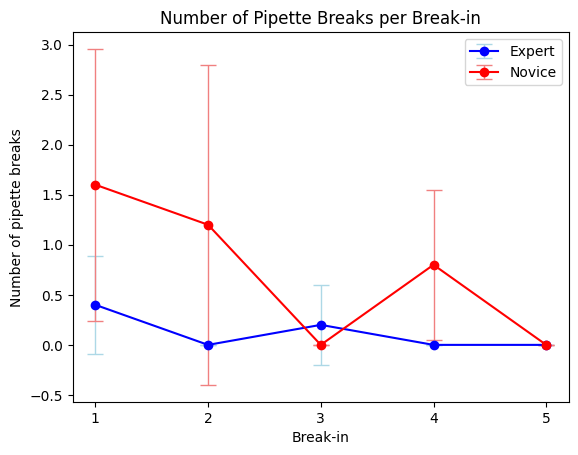

In [6]:
def get_pipette_breaks(data):
    #find number of pipette breaks per break-in
    pipette_breaks = []

    num_runs = len(data)

    for i in range(num_runs):
        run = data[i]
        break_in = 0
        run_breaks = []
        run_breaks.append(0)
        for time, event in run:
            if event == Events.PIPETTE_BROKEN.value:
                run_breaks[break_in] += 1
            elif event == Events.BREAK_IN.value:
                break_in += 1
                run_breaks.append(0)

        pipette_breaks.append(run_breaks)


    #pad with zeros and convert to numpy array
    pipette_breaks = fix_data_length(pipette_breaks)

    pipette_breaks = np.array(pipette_breaks)

    return pipette_breaks

pipette_breaks_expert = get_pipette_breaks(expert_data)
pipette_breaks_novice = get_pipette_breaks(novice_data)

create_graph(pipette_breaks_expert, pipette_breaks_novice, 'Number of Pipette Breaks per Break-in', 'Break-in', 'Number of pipette breaks')
#plt save



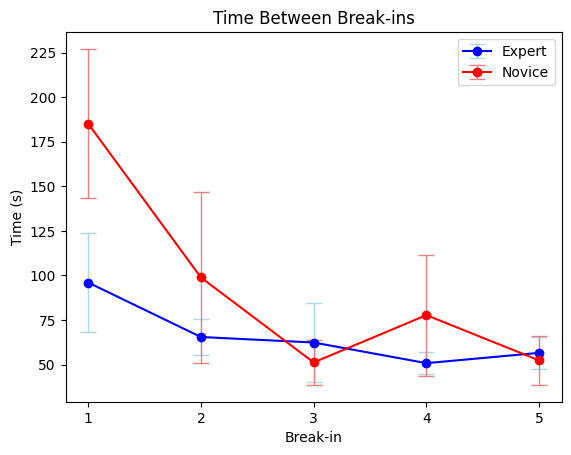

In [7]:

def get_break_ins(data):
    #find time required between break-ins
    break_in_times = []
    num_runs = len(data)
    for i in range(num_runs):
        run = data[i]
        break_in = 0
        run_times = []
        prev_time = 0

        for time, event in run:
            if event == Events.BREAK_IN.value:
                break_in += 1
                run_times.append(time - prev_time)
                prev_time = time
        break_in_times.append(run_times)

    break_in_times = fix_data_length(break_in_times)
    break_in_times = np.array(break_in_times)

    return break_in_times

break_in_times_expert = get_break_ins(expert_data)
break_in_times_novice = get_break_ins(novice_data)

create_graph(break_in_times_expert, break_in_times_novice, 'Time Between Break-ins', 'Break-in', 'Time (s)')